# TWISTTER US AIRLINE SENTIMENT ANALYSIS

In this project, I decided to analyze sentiment of us airline with 6 steps of CRISP-DM:
> 1. Business understanding
> 2. Data understanding 
> 3. Prepare data
> 4. Model data
> 5. Evaluation results
> 6. Deployment

## Business understanding

Twitter data describes the feedback of customers when using the services of US airlines. This data has been collected since February 2015 and contributors were asked to first categorize tweets as positive, negative, and neutral, and then to categorize negative reasons (such as " late flight" or "rude service"). We analyze the data to find factors that customer critize or praise.

## Import Required Libraries

In [93]:
import numpy as np
import pandas as pd
import re
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter
import plotly.subplots as sp

import nltk
import spacy
from nltk.stem.porter import PorterStemmer
import re
import time
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/huynguyenanh24/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Describe the dataset
### Load data

In [94]:
#Export dataset using pandas
df = pd.read_csv('./dataset/Tweets.csv')

#Show first 5 rows of dataset
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [95]:
#Show all types of features in the dataset
df.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [96]:
#Show the shape of dataset
df.shape

(14640, 15)

## Data preparation

In [97]:
#We filter only text and airline to analyze 
df = df[['airline_sentiment', 'airline', 'text']]

#Check if there is nan value
df.isnull().sum()

airline_sentiment    0
airline              0
text                 0
dtype: int64

In [98]:
enstopwords = stopwords.words("english") # List of stop words in English

def process_airline(content):
    # Convert all letters to lowercase 
    content = content.lower()
    # List of split words by space 
    content = [word for word in content.split()]
    # Join all the words without space
    content = ''.join(content)
    return content

def process_text(content):
    # Pick all alphabet characters - lowercase and uppercase...all others such as numbers and punctuations will be removed. Numbers or punctuations will be replaced by a whitespace
    content = re.sub('[^a-zA-Z]',' ',content)
    # Converting all letters to lowercase 
    content = content.lower()
    # Remove stopwords as well
    content = [word for word in content.split() if not word in enstopwords]
    # Join all the words in final content
    content = ' '.join(content)
    return content

def remove_airline(content):
    # Pick all alphabet characters - lowercase and uppercase...all others such as numbers and punctuations will be removed. Numbers or punctuations will be replaced by a whitespace
    content = re.sub('[^@a-zA-Z]',' ',content)
    # Remove airline name like @united from the string
    content = re.sub('@[a-zA-Z]+',' ',content)
    # Convert all letters to lowercase
    content = content.lower()
    # Remove all stop words
    content = [word for word in content.split() if not word in enstopwords]
    # Join all words in final content
    content = ' '.join(content)
    return content




In [99]:
# Convert all letters of airline to lowercase and join without space
df['airline'] = df['airline'].apply(process_airline)

# Remove all airline hastag from text
df['text_with_no_airlinehastag'] = df['text'].apply(remove_airline)

# Clean and process text
df['text'] = df['text'].apply(process_text)

# The following lines of code lemmatizes words
"""
Examples of lemmatization:
-> plays : play
-> corpora : corpus
-> better : good
"""
nlp = spacy.load("en_core_web_sm")
tmp = [] 
for doc in nlp.pipe(df['text'], batch_size=32, n_process=1, disable=["parser", "ner"]):
    tmp.append(' '.join([tok.lemma_ for tok in doc]))
df['text'] = tmp


## Descriptive Analytics

In [100]:
# Caculate percentage of positive, negative and neutral reviews of each airlines
df['count'] = 1
df_sen_per = df.groupby(['airline', 'airline_sentiment'])['airline','airline_sentiment','count'].sum().reset_index()
tmp = df_sen_per.groupby(['airline'])['airline', 'count'].sum()
df_sen_per = df_sen_per.merge(tmp,how = 'left', on = 'airline')
df_sen_per['per'] = df_sen_per['count_x']/df_sen_per['count_y']
df_sen_per = df_sen_per[['airline', 'airline_sentiment', 'per', 'count_x']]
df_sen_per.head()

/home/huynguyenanh24/anaconda3/envs/airline-tweets/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/home/huynguyenanh24/anaconda3/envs/airline-tweets/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,airline,airline_sentiment,per,count_x
0,american,negative,0.710402,1960
1,american,neutral,0.167814,463
2,american,positive,0.121783,336
3,delta,negative,0.429793,955
4,delta,neutral,0.325383,723


In [101]:
#Plot percentage of positive, negative and neutral reviews of each airlines
fig = px.bar(df_sen_per, x='airline', y='per', color='airline_sentiment')
fig.show()

In [102]:
#Plot number of positive, negative and neutral reviews of each airlines
fig = px.bar(df_sen_per, x='airline', y='count_x', color='airline_sentiment')
fig.show()

We can see that in 3 types of reviews, negative reviews account for the largest proportion and in 6 airlines, american, united, usairways have a higher negative contribution rate than the remaining 3 airlines.
Although the total number of reviews of delta, southwest, virginamerica is less than the other 3 airlines, they account for a higher percentage of positive reviews.

In [103]:
def ngrams(n, title, lis_type):
    """
    A Function to plot most common ngrams

    Input: ngram want to show, title of the chart and a list containing 3 lists of object: negative, posivte, neutral 

    Output: a graph of top 15 tokens ngrams appeared the most
    """

    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis_type, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='rocket', ax=j)
        
        axes[0].set_title('Positive')
        axes[1].set_title('Negative')
        axes[2].set_title('Neutral')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Word')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Word')
        axes[2].set_xlabel('Count')
        axes[2].set_ylabel('Word')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

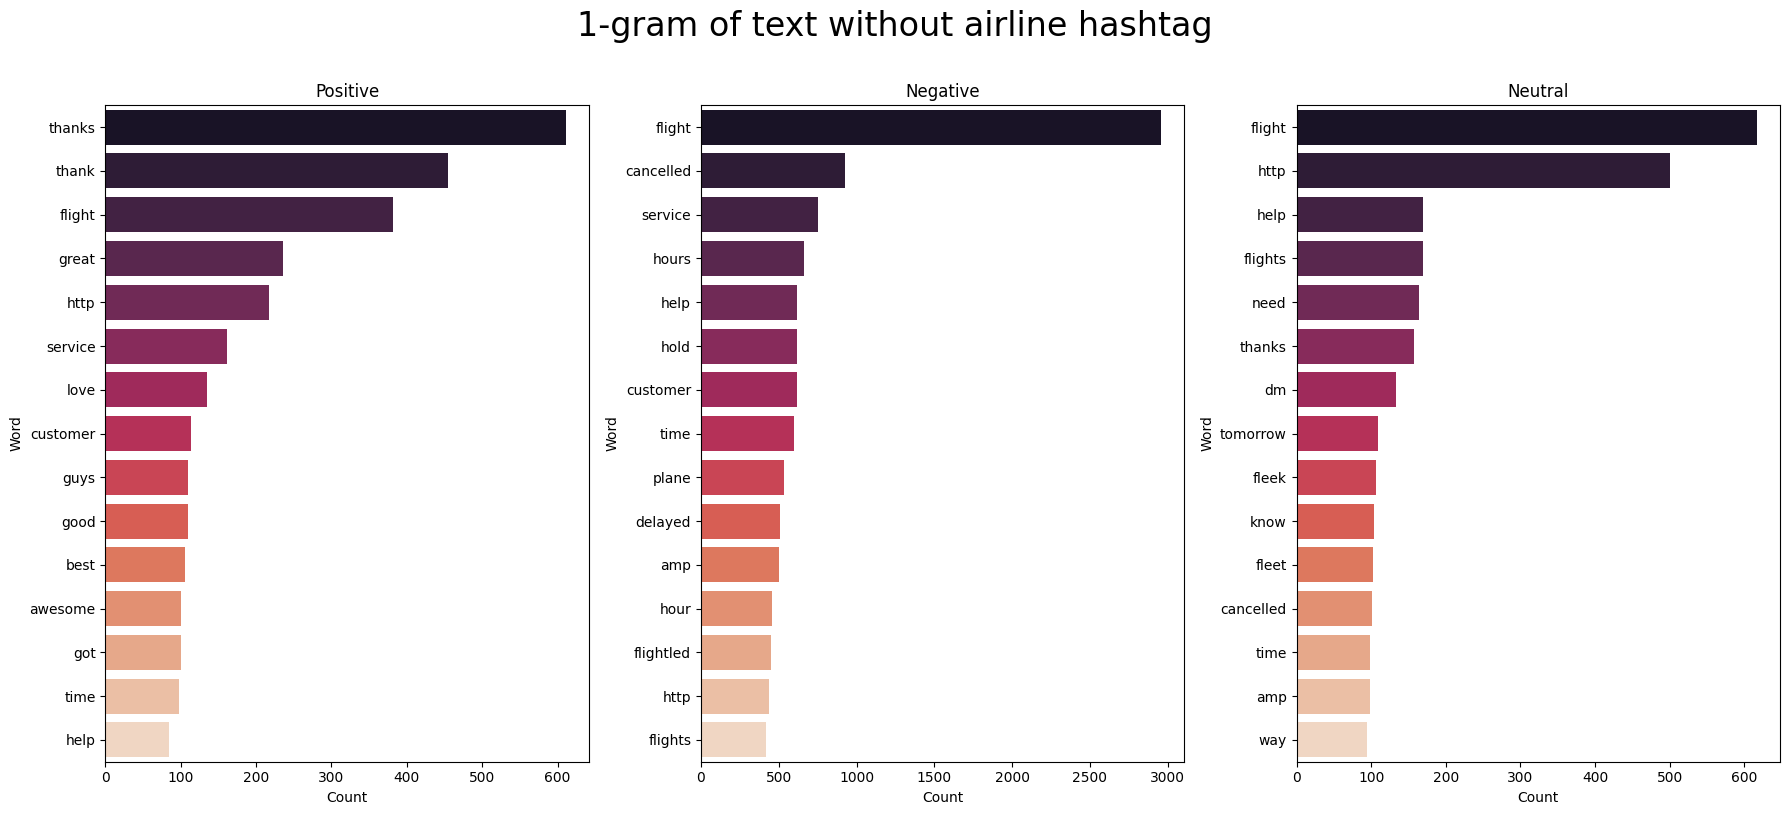

In [104]:
# 1-gram of text with no airline hastag
lis_text_with_no_airlinehastag = [
    df[df['airline_sentiment'] == 'positive']['text_with_no_airlinehastag'],
    df[df['airline_sentiment'] == 'negative']['text_with_no_airlinehastag'],
    df[df['airline_sentiment'] == 'neutral']['text_with_no_airlinehastag']
]
ngrams(1, "1-gram of text without airline hashtag", lis_text_with_no_airlinehastag)

Based on the above table, we can see that the words 'thank', 'great', 'customer', 'service' appear most in the positive review class. The words 'canceled', 'service', and 'hour' appear in the negative reviews class. So I guess the customer reviews are about the service of the airlines and the reason for the negative reviews are flight cancellations and flight delays.
For more certainty and information, see the 2-gram and 3-gram charts below.

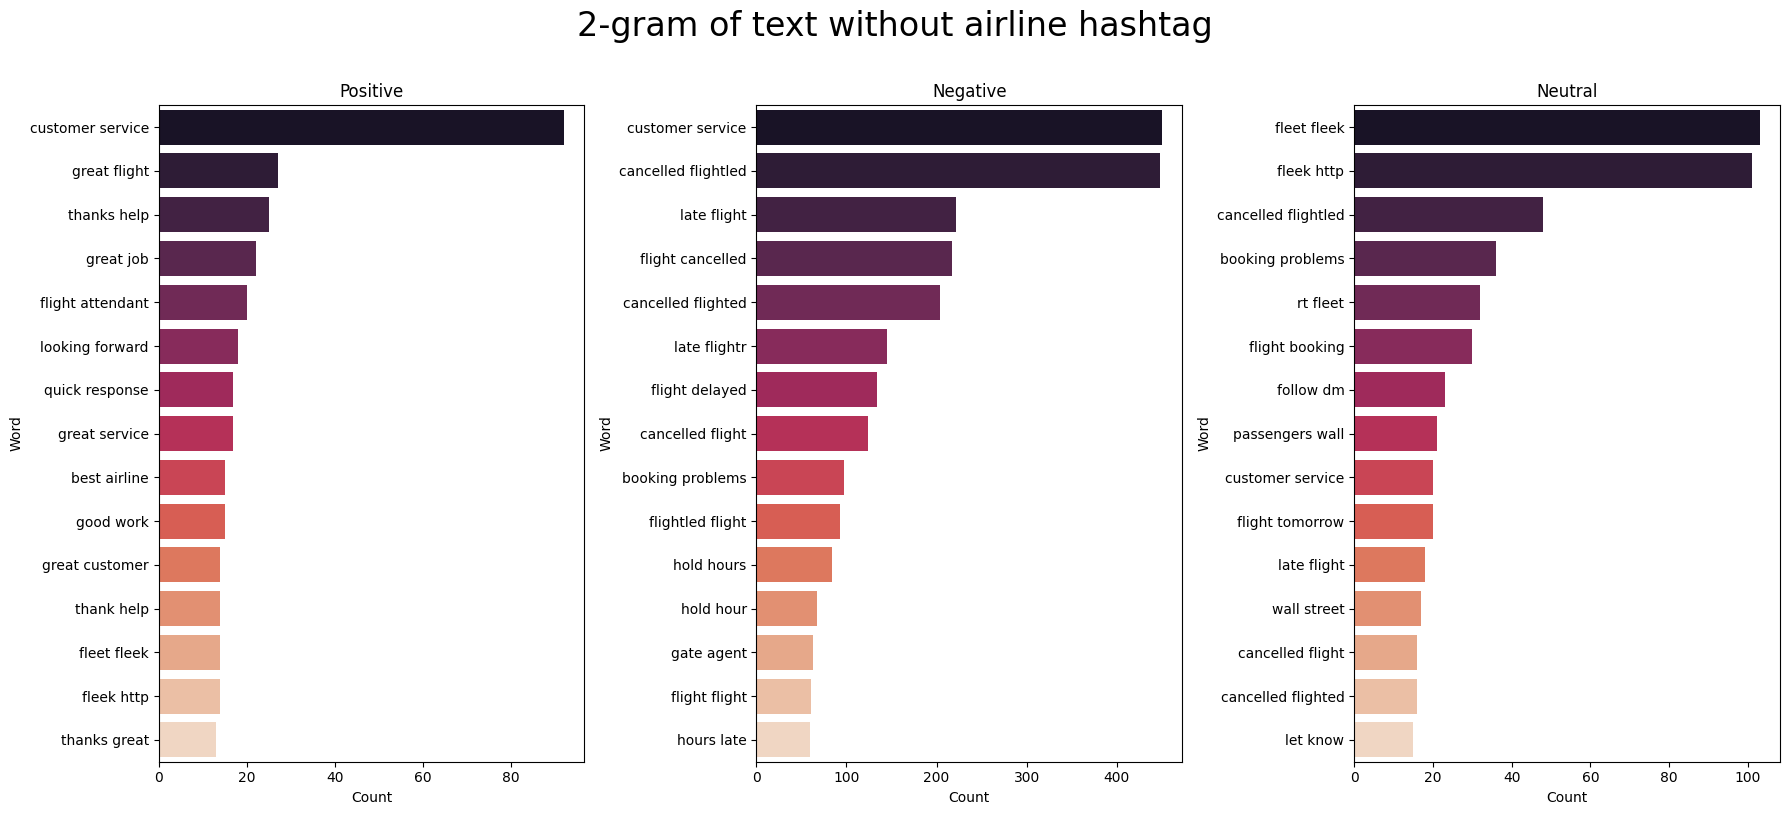

In [105]:
ngrams(2, "2-gram of text without airline hashtag", lis_text_with_no_airlinehastag)

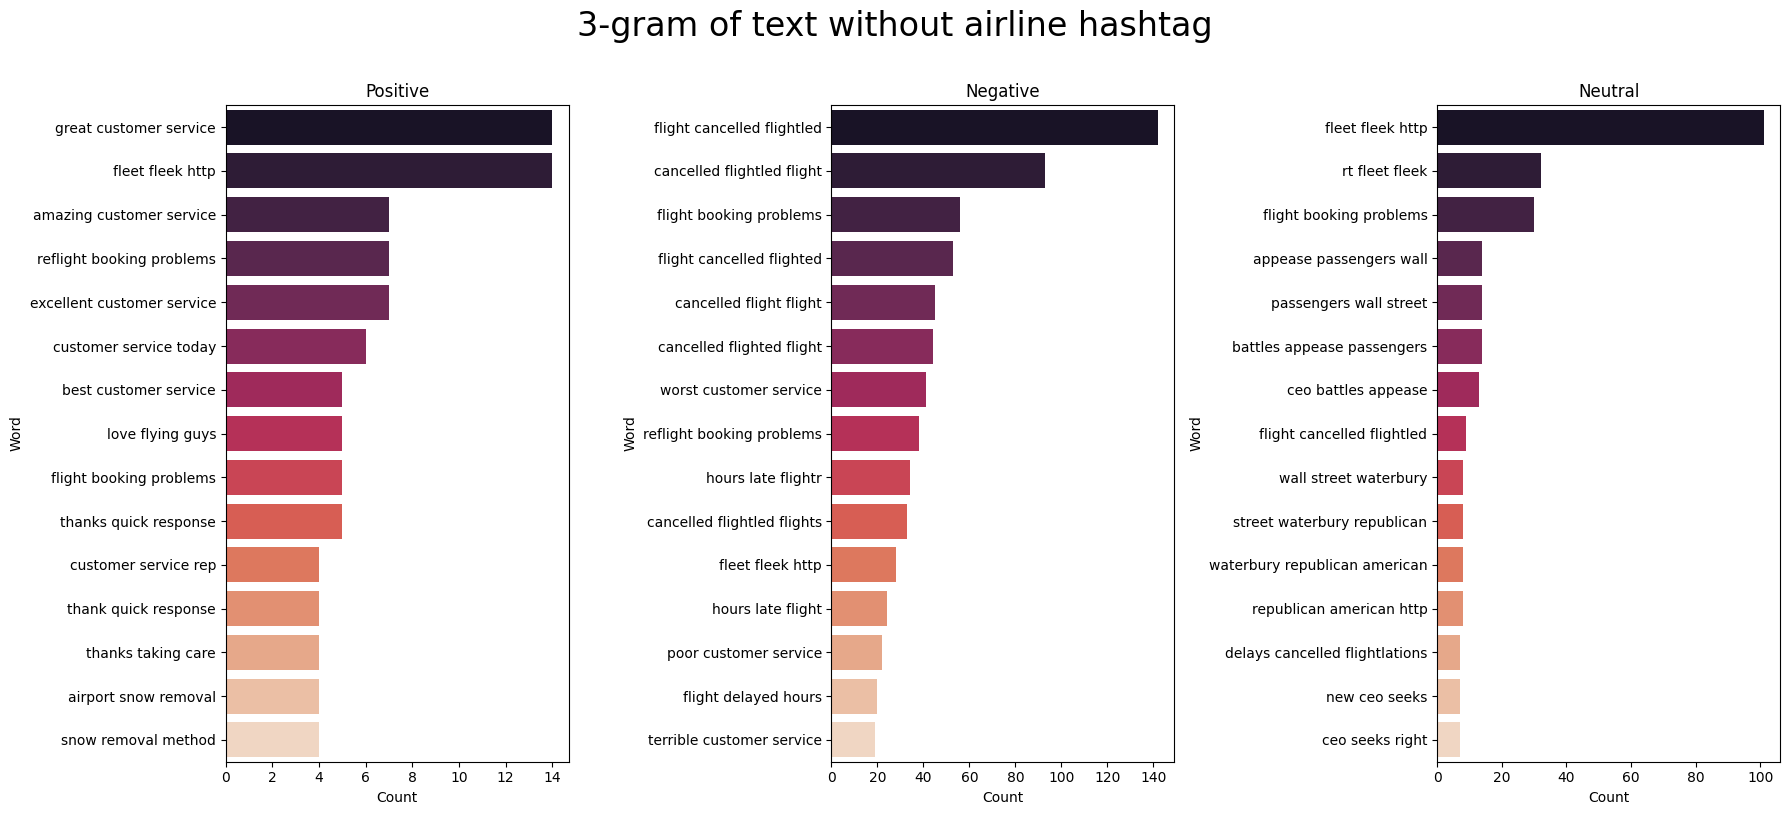

In [106]:
ngrams(3, "3-gram of text without airline hashtag", lis_text_with_no_airlinehastag)

Looking at the 2-gram and 3-gram charts, we can confirm that people complain about airline service because of flight delays, cancellations and booking problems.

# Model

In [107]:
#Convert label to numbers
map_label_dict = {'positive':1, 'negative':-1, 'neutral':0}
df = df.replace({'airline_sentiment':map_label_dict})

Train-test split

In [108]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'], df['airline_sentiment'], test_size=0.20, random_state=42)

### Transform text to vector
#### Count vectorizer

In [109]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer() 
# Fit and transform the training data.
count_train = count_vectorizer.fit_transform(X_train)
# Transform the test set 
count_test = count_vectorizer.transform(X_test)


#### Tfidf

In [110]:
#Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer()
#Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
#Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [111]:
""" 
Function that caculate accuracy, confusion matrix and classification report of model
"""
def evaluate(X_train, Y_train, X_test, Y_test, model):
    # Accuracy Score on Training Data
    X_train_prediction = model.predict(X_train)

    model_names = [name for name in globals() if globals()[name] is model]
    print("\n", model_names)

    training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
    print('Accuracy score on the training data: ',training_data_accuracy)

    X_test_prediction = model.predict(X_test)
    # test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
    # print classification report
    print("Accuracy score on the test data: ", accuracy_score(Y_test, X_test_prediction))
    print(classification_report(Y_test, X_test_prediction))
    
    plot_confusion_matrix(model, X_test, Y_test)

#### Logistic Regression

In [112]:
#Train Logistic Regression with grid search
lr = LogisticRegression(max_iter=500)

#Grid search to find the best hyperparameters (c_values)
def gc(model, X, y):
    c_values = [100, 10, 1.0, 0.1, 0.01]
    grid = dict(C=c_values)
    grid_search = GridSearchCV(estimator=model, param_grid=grid)
    grid_search.fit(X, y)
    return grid_search, grid_search.best_params_

model1_bow, best1 = gc(lr, count_train, Y_train)#Fit model with countvectorizer input vectors
model1_tfidf, best2 = gc(lr, tfidf_train, Y_train)#Fit model with tfidf input vectors

/home/huynguyenanh24/anaconda3/envs/airline-tweets/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/huynguyenanh24/anaconda3/envs/airline-tweets/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

In [113]:
best1, best2 #Print best C_values of countvectorizer and tfidf

({'C': 1.0}, {'C': 1.0})


 ['model1_bow']
Accuracy score on the training data:  0.9275956284153005
Accuracy score on the test data:  0.7940573770491803
              precision    recall  f1-score   support

          -1       0.86      0.89      0.87      1889
           0       0.60      0.57      0.58       580
           1       0.76      0.70      0.73       459

    accuracy                           0.79      2928
   macro avg       0.74      0.72      0.73      2928
weighted avg       0.79      0.79      0.79      2928


 ['model1_tfidf']
Accuracy score on the training data:  0.8689378415300546
Accuracy score on the test data:  0.7961065573770492
              precision    recall  f1-score   support

          -1       0.83      0.93      0.88      1889
           0       0.65      0.49      0.56       580
           1       0.79      0.63      0.70       459

    accuracy                           0.80      2928
   macro avg       0.76      0.68      0.71      2928
weighted avg       0.79      0.80    

/home/huynguyenanh24/anaconda3/envs/airline-tweets/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.

/home/huynguyenanh24/anaconda3/envs/airline-tweets/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



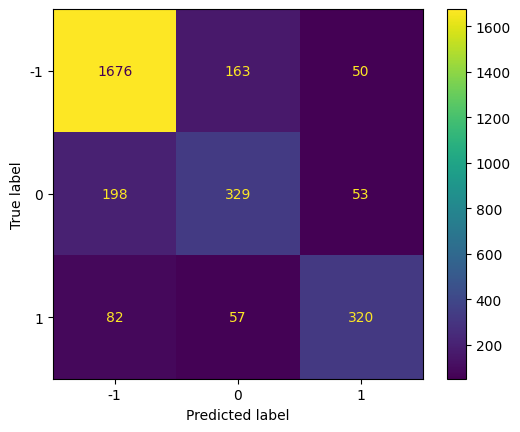

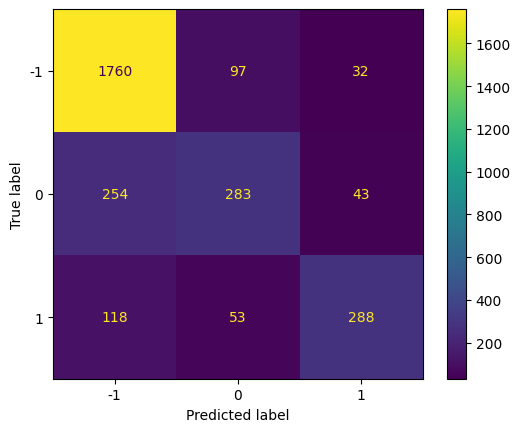

In [114]:
#Print accuracy, confusion matrix and classification report of 2 model 
evaluate(count_train, Y_train, count_test, Y_test, model1_bow) # Model of count vectorizer
evaluate(tfidf_train, Y_train, tfidf_test, Y_test, model1_tfidf)# Model of tf idf

Looking at the above results, we can see that the model identified the most wrong in the neutral reviews class and the two models gave approximately equal results in the accuracy of each class. Accuracy of both models is approximately 80%

#### Naive Bayes

In [115]:
# tune the hyperparameter  alpha for of count vectorizer input
for alpha in np.arange(0,1,.05):
    nb_classifier_tune = MultinomialNB(alpha=alpha)
    nb_classifier_tune.fit(count_train, Y_train)
    pred_tune = nb_classifier_tune.predict(count_test)
    score = accuracy_score(Y_test, pred_tune)
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

Alpha: 0.00 Score: 0.74385
Alpha: 0.05 Score: 0.77015
Alpha: 0.10 Score: 0.77357
Alpha: 0.15 Score: 0.77425
Alpha: 0.20 Score: 0.77561
Alpha: 0.25 Score: 0.77698
Alpha: 0.30 Score: 0.77766
Alpha: 0.35 Score: 0.77801
Alpha: 0.40 Score: 0.77971
Alpha: 0.45 Score: 0.78176
Alpha: 0.50 Score: 0.78347
Alpha: 0.55 Score: 0.78313
Alpha: 0.60 Score: 0.78415
Alpha: 0.65 Score: 0.78449
Alpha: 0.70 Score: 0.78415
Alpha: 0.75 Score: 0.78313
Alpha: 0.80 Score: 0.78313
Alpha: 0.85 Score: 0.78005
Alpha: 0.90 Score: 0.77971
Alpha: 0.95 Score: 0.77698


/home/huynguyenanh24/anaconda3/envs/airline-tweets/lib/python3.7/site-packages/sklearn/naive_bayes.py:557: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10



In [116]:
# Tune the hyperparameter  alpha for of tfidf input
for alpha in np.arange(0,1,.05):
    nb_classifier_tune = MultinomialNB(alpha=alpha)
    nb_classifier_tune.fit(tfidf_train, Y_train)
    pred_tune = nb_classifier_tune.predict(tfidf_test)
    score = accuracy_score(Y_test, pred_tune)
    print("Alpha: {:.2f}  Score: {:.5f}".format(alpha, score))


Alpha: 0.00  Score: 0.74488
Alpha: 0.05  Score: 0.76093
Alpha: 0.10  Score: 0.76127
Alpha: 0.15  Score: 0.75820
Alpha: 0.20  Score: 0.75239
Alpha: 0.25  Score: 0.75068
Alpha: 0.30  Score: 0.74419
Alpha: 0.35  Score: 0.74078
Alpha: 0.40  Score: 0.73907
Alpha: 0.45  Score: 0.73668
Alpha: 0.50  Score: 0.72883
Alpha: 0.55  Score: 0.72336
Alpha: 0.60  Score: 0.72199
Alpha: 0.65  Score: 0.71790
Alpha: 0.70  Score: 0.71380
Alpha: 0.75  Score: 0.71004
Alpha: 0.80  Score: 0.70799
Alpha: 0.85  Score: 0.70594
Alpha: 0.90  Score: 0.70458
Alpha: 0.95  Score: 0.70184


/home/huynguyenanh24/anaconda3/envs/airline-tweets/lib/python3.7/site-packages/sklearn/naive_bayes.py:557: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10



/home/huynguyenanh24/anaconda3/envs/airline-tweets/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.

/home/huynguyenanh24/anaconda3/envs/airline-tweets/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.




 ['model2_bow']
Accuracy score on the training data:  0.8475922131147541
Accuracy score on the test data:  0.7844945355191257
              precision    recall  f1-score   support

          -1       0.81      0.94      0.87      1889
           0       0.65      0.42      0.51       580
           1       0.80      0.60      0.69       459

    accuracy                           0.78      2928
   macro avg       0.75      0.65      0.69      2928
weighted avg       0.77      0.78      0.77      2928


 ['model2_tfidf']
Accuracy score on the training data:  0.8645833333333334
Accuracy score on the test data:  0.7612704918032787
              precision    recall  f1-score   support

          -1       0.76      0.96      0.85      1889
           0       0.68      0.33      0.45       580
           1       0.83      0.47      0.60       459

    accuracy                           0.76      2928
   macro avg       0.76      0.59      0.63      2928
weighted avg       0.76      0.76    

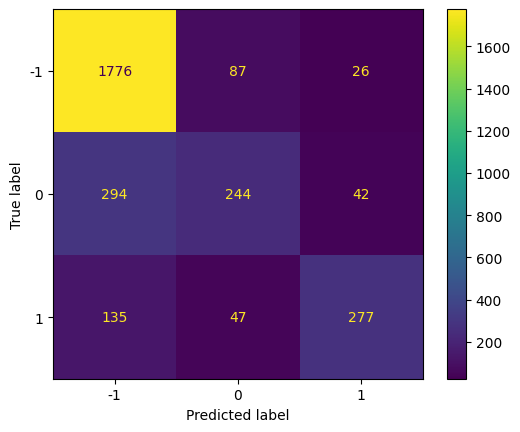

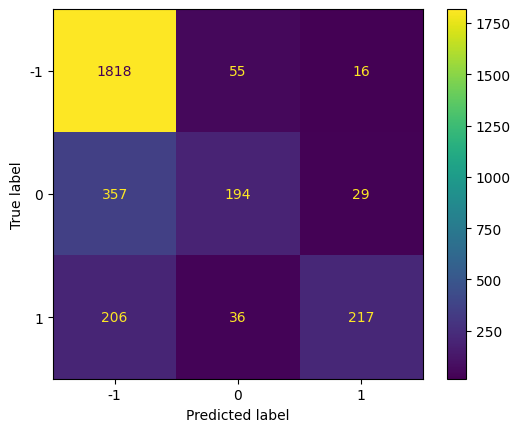

In [117]:
model2_bow = MultinomialNB(alpha = 0.65)
model2_tfidf = MultinomialNB(alpha = 0.10)

model2_bow.fit(count_train, Y_train) #Fit model with count vectorizer
model2_tfidf.fit(tfidf_train, Y_train)#Fit model with tfidf

evaluate(count_train, Y_train, count_test, Y_test, model2_bow)#Result of count vectorizer
evaluate(tfidf_train, Y_train, tfidf_test, Y_test, model2_tfidf)#Result of ifidf 

As we can see accucary of neutral class still lower than 2 other class. All the metrics in classification reports are lower than Logistic Regression